### Make environment

In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

import numpy as np

import torch

from src.utils.constants import ParamTuple
from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.visualization import plot_environment

height = 7
width = 7
rewards = np.zeros((height, width))
wall_states = np.zeros((height, width))

rewards[6,0] = 1
rewards[6,6] = 3

# rewards[5,0] = -1
# rewards[4,0] = -1

rewards = rewards.flatten()


goal_states = np.where(rewards > 0)[0]

wall_states[2,0] = 1
# wall_states[4,1] = 1

wall_states = wall_states.flatten()
wall_states = np.where(wall_states > 0)[0]

agent_p = 0.9
agent_gamma = 0.7
p_true=1

true_params = ParamTuple(agent_p, agent_gamma, rewards)

wall_states = [14]

T_true = transition_matrix(height, width, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)

T_torch = torch.tensor(T_True, dtype=torch.float32)
R_torch = torch.tensor(rewards, dtype=torch.float32)
gamma_torch = torch.tensor(agent_gamma, dtype=torch.float32)

### Soft Bellman Operator for fixed point.

In [2]:
def soft_bellman_update_V(R, gamma, T, V):
    return torch.log(torch.sum(torch.exp(torch.matmul(T, R+gamma*V)), axis=1))

def soft_bellman_FP_V(R, gamma, T, V):
    return soft_bellman_update_V(R, gamma, T, V) - V

def soft_V_iteration_torch(R, gamma, T, V_init=None, tol=1e-6):
    if V_init is None:
        V_init = torch.zeros(49)

    V = V_init
    
    while True:
        V_new = soft_bellman_update_V(R, gamma,T, V)
        if torch.max(torch.abs(V - V_new)) < tol:
            break
        V = V_new
    return V

Calculate Derivative of Value Function.

In [3]:
def differentiate_V(R: torch.tensor, gamma: torch.tensor, T: torch.tensor, V: torch.tensor):

    '''
    Calculate the derivative of the value function V with respect to the reward function R and the transition matrix T.

    Args:
    - R (torch.tensor): The reward function R of shape (n_states,)
    - gamma (torch.tensor): The discount factor gamma
    - T (torch.tensor): The transition matrix T of shape (n_states, n_actions, n_states)
    - V (torch.tensor): Initialization of the value function V of shape (n_states,), optional.

    Returns:
    - V_star (torch.tensor): The optimal value function V, shape (n_states,)
    - R_grad_out (torch.tensor): The gradient of the value function V with respect to the reward function R, shape (n_states,) evaluated at V_star
    - T_grad_out (torch.tensor): The gradient of the value function V with respect to the transition matrix T, shape (n_states, n_actions, n_states) evaluated at V_star

    Notes:
    - We replaced the hard max in the Bellman operator with a soft max to make the operator differentiable. Thereby, we no longer converge to the "true" value function
    but rather to an approximation.
    '''

    #Perform value iteration to find a fixed point of the Bellman operator.
    V_star = soft_V_iteration_torch(R, gamma, T, V_init=V, tol=1e-6)

    #Calculate the gradient of the value function using the implicit function theorem.
    # A closed form expression for V is given by psi.
    R_grad = torch.autograd.Variable(R, requires_grad=True)
    T_grad = torch.autograd.Variable(T, requires_grad=True)
    V_star_grad = torch.autograd.Variable(V_star, requires_grad=True)

    df_dtheta = soft_bellman_FP_V(R = R_grad, gamma=gamma, T=T_grad, V = V_star_grad)
    df_dtheta.backward(torch.ones_like(df_dtheta))

    Jacobian = torch.autograd.functional.jacobian(func=soft_bellman_FP_V, inputs=(R_grad, gamma, T_grad, V_star_grad))
    df_dw = Jacobian[3]
    del Jacobian

    #Inverse of Jacobian.
    df_dw_inv = torch.inverse(df_dw)

    R_grad_out = - torch.einsum('ij,j->i', df_dw_inv, R_grad.grad)
    T_grad_out = - torch.einsum('ij,jkl->ikl', df_dw_inv, T_grad.grad)

    return V_star, R_grad_out, T_grad_out

In [4]:
V_star, R_grad_out, T_grad_out = differentiate_V(R = R_torch, gamma = gamma_torch, T = T_torch, V = None)

/home/paul/.local/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


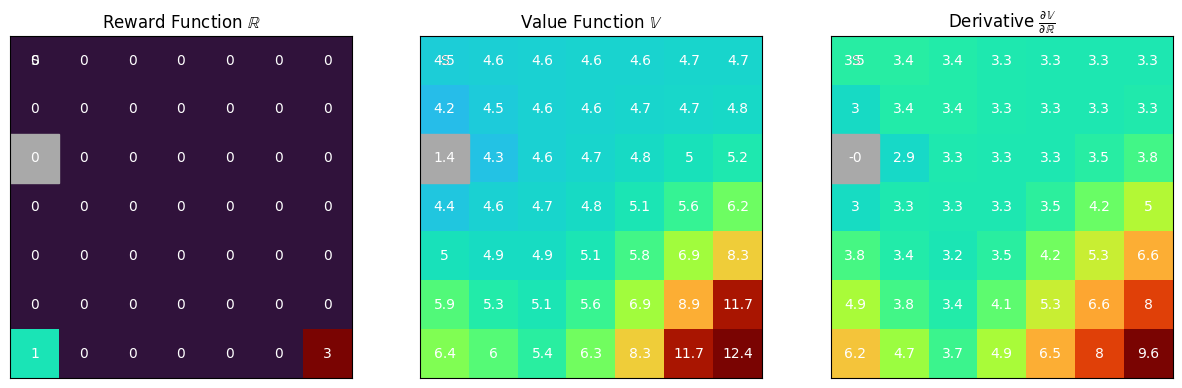

In [5]:
import matplotlib.pyplot as plt
from src.worlds.mdp2d import Experiment_2D

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_environment(reward_function=R_torch.detach().numpy().reshape(height, width), wall_states=wall_states, ax=axs[0], title=r"Reward Function $\mathbb{R}$")
plot_environment(reward_function=V_star.detach().numpy().reshape(height, width), wall_states=wall_states, ax = axs[1], title=r"Value Function $\mathbb{V}$")

def make_world(
    height: int,
    width: int,
    rewards: np.array,
    absorbing_states: list,
    wall_states: list
) -> Experiment_2D:

    experiment = Experiment_2D(
        height,
        width,
        rewards = rewards,
        absorbing_states = absorbing_states,
        wall_states=wall_states,
    )

    return experiment
plot_environment(reward_function=R_grad_out.detach().numpy().reshape(height, width), wall_states=wall_states, ax = axs[2], title=r"Derivative $\frac{\partial \mathbb{V}}{\partial \mathbb{R}}$")

## Check Effect on Behavior Map

In [6]:
from src.worlds.mdp2d import Experiment_2D

def make_world(
    height: int,
    width: int,
    rewards: np.array,
    absorbing_states: list,
    wall_states: list
) -> Experiment_2D:

    experiment = Experiment_2D(
        height,
        width,
        rewards = rewards,
        absorbing_states = absorbing_states,
        wall_states=wall_states,
    )

    return experiment

custom_world = make_world(height=height,
                          width=width,
                          rewards=rewards,
                          absorbing_states=goal_states,
                          wall_states=wall_states)

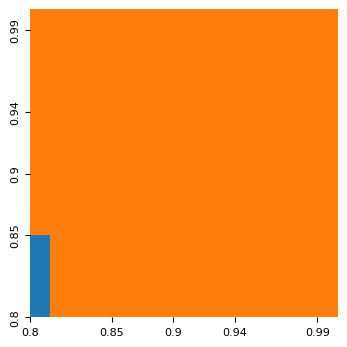

In [7]:
import src.utils.behavior_map as bm

granularity = 15

# Set up parameters to search over
probs = np.linspace(0.8, 0.99, granularity)
gammas = np.linspace(0.8, 0.99, granularity)

out = bm.plot_bmap(
    world=custom_world,
    gammas=gammas,
    probs=probs,
    plot = True
)

In [8]:
out

ExperimentResult(data=array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32), p2idx={'DRDDDDDL': 0, 'DRDDDDRRRRDR': 1}, pidx2states={0: [0, 7, 8, 15, 22, 29, 36, 43, 42], 1: [0, 7, 8, 15, 22, 29, 36, 37, 38, 39, 40, 47, 48]})

In [9]:
from scipy import stats

In [10]:
def compute_covers(bm_out):

    '''
    Computes the entropy of the Behavior Map and for each behavior in the behavior map the proportion of the BM that is covered by the respective Behavior.

    Args:
    - bm_out (dict): The output of the behavior map function.

    Returns:
    - covers (dict): A dictionary containing the proportion of the BM that is covered by the respective Behavior.
    - max_ent_cover (float): The proportion of the BM that would be covered by each behavior in the case of maximum entropy.
    '''

    _behaviors = np.unique(bm_out.data)
    n_behavior_samples = bm_out.data.size
    covers = {}

    for b in _behaviors:
        covers[b] = np.sum(bm_out.data == b) / n_behavior_samples

    max_ent_cover = 1/len(_behaviors)

    return covers, max_ent_cover

In [11]:
from copy import deepcopy

In [12]:
def gradient_updates_R(world, bm_out, stepsize: float = 0.001, n_iterations: int = 20):

    '''
    Perform gradient updates on the reward function R to maximize the entropy of the behavior map.

    Args:
    - world (Experiment_2D): The world in which the agent is acting.
    - bm_out (dict): The output of the behavior map function.
    - stepsize (float): The stepsize of the gradient updates.
    - n_iterations (int): The number of iterations to run.

    Returns:
    - R (torch.tensor): The updated reward function R.
    '''
    covers, max_ent_cover = compute_covers(bm_out)

    # Initialize learning parameters
    R = torch.tensor(world.rewards, dtype=torch.float32, requires_grad=False)
    V_star = torch.zeros_like(R)

    for _ in range(n_iterations):


        # Compute the gradient of the value function with respect to the reward function and the transition matrix.
        V_star, R_grad_out, _ = differentiate_V(R = R, gamma = gamma_torch, T = T_torch, V = V_star)


        # Update the reward function
        for behavior_idx in covers:

            cover = covers[behavior_idx]
            _visited_states = bm_out.pidx2states[behavior_idx]
            _visited_states = _visited_states[:-1]

            _masked_gradient_R = torch.zeros_like(R_grad_out)
            _masked_gradient_R[_visited_states] = R_grad_out[_visited_states]

            if cover > max_ent_cover:
                #Inhibit Behavior.
                R = R - stepsize * _masked_gradient_R
                

            else:
                #Excite Behavior.
                R = R + stepsize * _masked_gradient_R

    
    return R
        

In [14]:
R_new = gradient_updates_R(custom_world, out, stepsize=0.001, n_iterations=25)
R_new = R_new.detach().numpy()

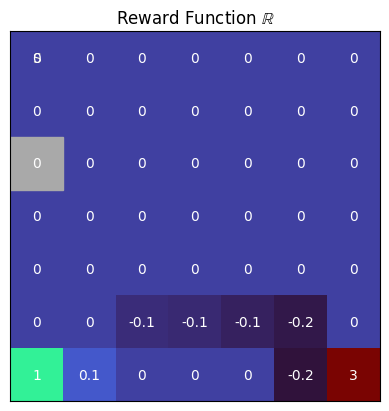

In [15]:
plot_environment(reward_function=R_new.reshape(height, width), wall_states=wall_states, title=r"Reward Function $\mathbb{R}$")

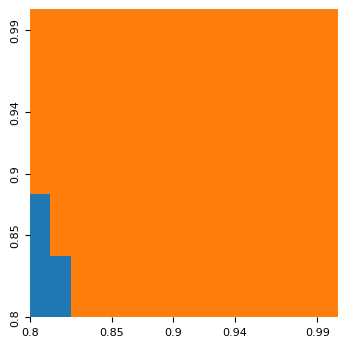

In [16]:
updated_world = make_world(height=height,
                          width=width,
                          rewards=R_new,
                          absorbing_states=goal_states,
                          wall_states=wall_states)

import src.utils.behavior_map as bm

granularity = 15

# Set up parameters to search over

out = bm.plot_bmap(
    world=updated_world,
    gammas=gammas,
    probs=probs,
    plot = True
)

In [17]:
compute_covers(out)

({0: 0.04, 1: 0.96}, 0.5)

In [47]:
def BM_search(world, n_compute_BM: int, n_iterations_gradient: int = 20, stepsize_gradient: float = 0.01, track_entropies: bool = False):

    '''
    Find a reward function that maximizes the entropy of the Behavior Map.

    Args:
    TODO    
    '''

    _world = deepcopy(world)
    R = _world.rewards
    _max_ent = -np.inf
    max_ent_R = _world.rewards

    if track_entropies:
        entropies = []
        max_ent_possible_list = []

        

    for i in range(n_compute_BM):

        print(f"Computing BM {i} of {n_compute_BM}")

        # Compute Behavior Map
        bm_out = bm.plot_bmap(world=_world, gammas=gammas, probs=probs)

        #Compute entropy of BM
        cover, max_ent_prob = compute_covers(bm_out)
        entropy_BM = stats.entropy(list(cover.values()))

        if entropy_BM > _max_ent:
            max_ent_possible = stats.entropy(np.repeat(max_ent_prob, repeats=int(1/max_ent_prob)))
            print(f"New Maximum Entropy Reward Function! Entropy: {entropy_BM}. Maximum Entropy possible: {max_ent_possible}.")
            _max_ent = entropy_BM
            max_ent_R = R

        if track_entropies:
            entropies.append(entropy_BM)
            max_ent_possible_list.append(max_ent_possible)

        # Perform Gradient Updates on Reward Function to maximize entropy of BM.
        R = gradient_updates_R(world=_world, bm_out=bm_out, stepsize=stepsize_gradient, n_iterations=n_iterations_gradient)

        #Update Reward Function
        _world.rewards = R.detach().numpy()

    if track_entropies:
        return max_ent_R, entropies, max_ent_possible_list

    return max_ent_R



In [48]:
import time
episodes = 3
all_entropies = []
all_max_entropies = []
all_durations = []

for episode in range(episodes):
    start_time = time.time()
    
    _, entropies, max_entropies = BM_search(custom_world, n_compute_BM=15, n_iterations_gradient=30, stepsize_gradient=0.005,
                                            track_entropies=True)
    
    end_time = time.time()
    duration = end_time - start_time

    all_entropies.append(entropies)
    all_max_entropies.append(max_entropies)
    all_durations.append(duration)

Computing BM 0 of 15
New Maximum Entropy Reward Function! Entropy: 0.08925980451596265. Maximum Entropy possible: 0.6931471805599453.
Computing BM 1 of 15
New Maximum Entropy Reward Function! Entropy: 0.3669249912727096. Maximum Entropy possible: 0.6931471805599453.
Computing BM 2 of 15
New Maximum Entropy Reward Function! Entropy: 0.6199868019113608. Maximum Entropy possible: 0.6931471805599453.
Computing BM 3 of 15
New Maximum Entropy Reward Function! Entropy: 0.6859298002523728. Maximum Entropy possible: 0.6931471805599453.
Computing BM 4 of 15
New Maximum Entropy Reward Function! Entropy: 0.6926631518430203. Maximum Entropy possible: 0.6931471805599453.
Computing BM 5 of 15
New Maximum Entropy Reward Function! Entropy: 0.7255590508392825. Maximum Entropy possible: 1.0986122886681096.
Computing BM 6 of 15
Computing BM 7 of 15
Computing BM 8 of 15
Computing BM 9 of 15
Computing BM 10 of 15
Computing BM 11 of 15
Computing BM 12 of 15
Computing BM 13 of 15
Computing BM 14 of 15
Computi

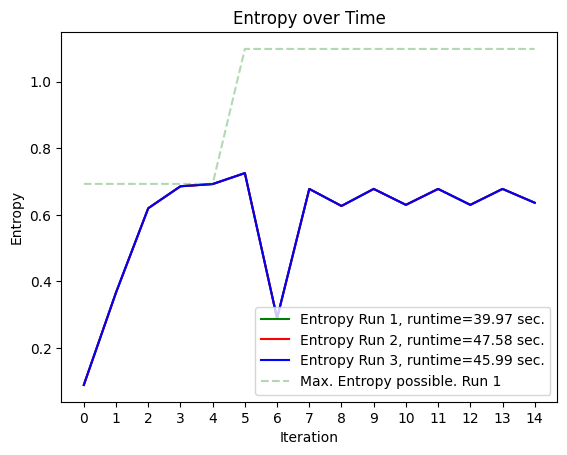

In [57]:
import matplotlib.pyplot as plt

# Plot all_entropies over time
plt.plot(all_entropies[0], "-g", label = f"Entropy Run 1, runtime={round(all_durations[0], 2)} sec.")
plt.plot(all_entropies[1], "-r", label = f"Entropy Run 2, runtime={round(all_durations[1], 2)} sec.")
plt.plot(all_entropies[2], "-b", label = f"Entropy Run 3, runtime={round(all_durations[2], 2)} sec.")

plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.title('Entropy over Time')

# Add maximum entropy as a horizontal line
plt.plot(all_max_entropies[0], color='green', linestyle='--', alpha=0.3, label=f'Max. Entropy possible. Run 1')
# plt.plot(all_max_entropies[0], color='green', alpha=0.3, linestyle='--', label=f'Max. Entropy possible. Run 1')
# plt.plot(all_max_entropies[1], color='red', alpha=0.3, linestyle='--', label=f'Max. Entropy possible. Run 2')
# plt.plot(all_max_entropies[2], color='blue', alpha=0.3, linestyle='--', label=f'Max. Entropy possible. Run 3')

# Add x-axis ticks only at integer values
plt.xticks(range(len(all_entropies[0])), range(len(all_entropies[0])))

# Add runtime as text

# Show the plot
plt.legend(loc="lower right")
plt.show()


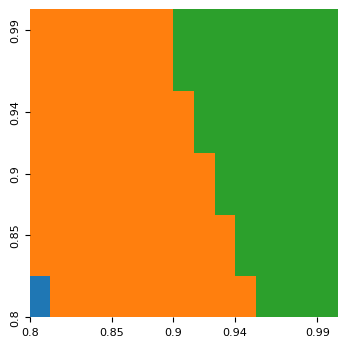

In [56]:
perturbed_world = deepcopy(custom_world)
perturbed_world.rewards = perturbed_R.detach().numpy()

out = bm.plot_bmap(
    world=perturbed_world,
    gammas=gammas,
    probs=probs,
    plot = True
)

In [57]:
out

ExperimentResult(data=array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]], dtype=int32), p2idx={'DL': 0, 'DRDDDDDD': 1, 'DRDDDDDRRRRR': 2}, pidx2states={0: [0, 7, 7], 1: [0, 7, 8, 15, 22, 29, 36, 43, 43], 2: [0, 7, 8, 15, 22, 29, 36, 43, 44, 

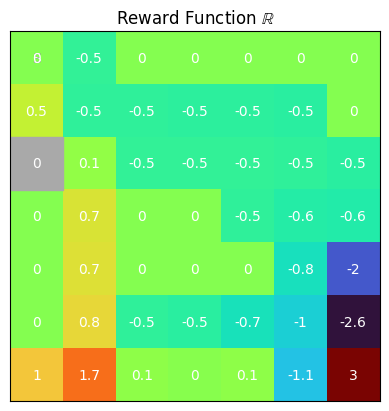

In [58]:
plot_environment(reward_function=perturbed_world.rewards.reshape(height, width), wall_states=wall_states, title=r"Reward Function $\mathbb{R}$")
